# Model Development with Optuna Hyperparameter Tuning

This notebook implements hyperparameter tuning using Optuna for the following models:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost
- CatBoost

The data processing and SMOTE application match the original `03_model_deploment.ipynb`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import optuna
import warnings

warnings.filterwarnings('ignore')
RANDOM_STATE = 42

### Load and Preprocess Data

In [2]:
train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

# Seperate features and target
target = 'Churn'
X_train_ber_res = train_df.drop(target, axis=1)
y_train_ber_res = train_df[target]
X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

Train shape: (5634, 50)
Test shape: (1409, 50)


### Apply SMOTE

In [3]:
print("Original Class Distribution:", Counter(y_train_ber_res))

# Apply SMOTE
smote = SMOTE(random_state=RANDOM_STATE)
X_train, y_train = smote.fit_resample(X_train_ber_res, y_train_ber_res)

print("Resampled Class Distribution:", Counter(y_train))

Original Class Distribution: Counter({0: 4139, 1: 1495})
Resampled Class Distribution: Counter({0: 4139, 1: 4139})


### Define Optuna Objectives

In [4]:
def objective_lr(trial):
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])
    
    # penalty depends on solver
    if solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty_liblinear', ['l1', 'l2'])
    elif solver == 'saga':
        penalty = trial.suggest_categorical('penalty_saga', ['l1', 'l2', 'elasticnet'])
    else:
        penalty = 'l2'
        
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)

    clf = LogisticRegression(
        C=C, 
        solver=solver, 
        penalty=penalty, 
        l1_ratio=l1_ratio,
        random_state=RANDOM_STATE, 
        max_iter=1000
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=RANDOM_STATE
    )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

def objective_xgb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    
    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        random_state=RANDOM_STATE,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1
    )
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

def objective_cat(trial):
    iterations = trial.suggest_int('iterations', 50, 500)
    depth = trial.suggest_int('depth', 4, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 10)
    
    clf = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        random_seed=RANDOM_STATE,
        verbose=0,
        thread_count=-1
    )
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')
    return scores.mean()

### Run Optimization

In [5]:
best_models = {}
best_params = {}

studies = {
    'Logistic Regression': objective_lr,
    'Decision Tree': objective_dt,
    'RandomForest': objective_rf,
    'XGBoost': objective_xgb,
    'CatBoost': objective_cat
}

for name, objective in studies.items():
    print(f"Optimizing {name}...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20) # 20 trials for demonstration
    
    print(f"Best params for {name}: {study.best_params}")
    best_models[name] = study.best_trial.value
    best_params[name] = study.best_params
    
print("\nOptimization Complete.")

[I 2026-01-18 22:35:43,687] A new study created in memory with name: no-name-dc7b0cc0-0e94-46fe-a415-a799f24b5b13


Optimizing Logistic Regression...


[I 2026-01-18 22:35:43,895] Trial 0 finished with value: 0.7708177304371999 and parameters: {'C': 0.007157868790245886, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}. Best is trial 0 with value: 0.7708177304371999.
[I 2026-01-18 22:35:44,119] Trial 1 finished with value: 0.8007398193053161 and parameters: {'C': 0.007952491254378516, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.8007398193053161.
[I 2026-01-18 22:35:44,397] Trial 2 finished with value: 0.8341477892831305 and parameters: {'C': 0.22977231669904333, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 2 with value: 0.8341477892831305.
[I 2026-01-18 22:35:44,930] Trial 3 finished with value: 0.8481506918656091 and parameters: {'C': 0.2798704607010932, 'solver': 'lbfgs'}. Best is trial 3 with value: 0.8481506918656091.
[I 2026-01-18 22:35:45,492] Trial 4 finished with value: 0.8494815405168346 and parameters: {'C': 0.4326222201554303, 'solver': 'lbfgs'}. Best is trial 4 with value: 0.8494815405168346.
[I 

Best params for Logistic Regression: {'C': 0.4466241977543894, 'solver': 'lbfgs'}
Optimizing Decision Tree...


[I 2026-01-18 22:37:38,017] Trial 0 finished with value: 0.7982687805613418 and parameters: {'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.7982687805613418.
[I 2026-01-18 22:37:38,263] Trial 1 finished with value: 0.7889058459183064 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7982687805613418.
[I 2026-01-18 22:37:38,570] Trial 2 finished with value: 0.8033521920254876 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 2 with value: 0.8033521920254876.
[I 2026-01-18 22:37:38,923] Trial 3 finished with value: 0.8023318319613008 and parameters: {'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 2 with value: 0.8033521920254876.
[I 2026-01-18 22:37:39,344] Trial 4 finished with value: 0.7854454798887633 and parameter

Best params for Decision Tree: {'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 5, 'criterion': 'entropy'}
Optimizing RandomForest...


[I 2026-01-18 22:37:47,382] Trial 0 finished with value: 0.8201084099111147 and parameters: {'n_estimators': 221, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.8201084099111147.
[I 2026-01-18 22:37:49,500] Trial 1 finished with value: 0.8294536024434916 and parameters: {'n_estimators': 211, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8294536024434916.
[I 2026-01-18 22:37:52,069] Trial 2 finished with value: 0.8438888836012026 and parameters: {'n_estimators': 264, 'max_depth': 25, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8438888836012026.
[I 2026-01-18 22:37:54,381] Trial 3 finished with value: 0.8396929131705587 and parameters: {'n_estimators': 233, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8438888836012026.
[I 2026-01-18 22:37:56,246] Trial 4 finished with value: 0.8265538111840902 and parameter

Best params for RandomForest: {'n_estimators': 277, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 3}
Optimizing XGBoost...


[I 2026-01-18 22:38:31,344] Trial 0 finished with value: 0.8118553019746582 and parameters: {'n_estimators': 209, 'max_depth': 3, 'learning_rate': 0.013212610087695259, 'subsample': 0.6031807987779823, 'colsample_bytree': 0.8867138189072564, 'gamma': 3.7652064537964014}. Best is trial 0 with value: 0.8118553019746582.
[I 2026-01-18 22:38:32,246] Trial 1 finished with value: 0.8548544745341395 and parameters: {'n_estimators': 278, 'max_depth': 3, 'learning_rate': 0.19810939323433518, 'subsample': 0.9057940286097972, 'colsample_bytree': 0.5236719659959407, 'gamma': 0.28741585743546183}. Best is trial 1 with value: 0.8548544745341395.
[I 2026-01-18 22:38:32,639] Trial 2 finished with value: 0.8463862884374396 and parameters: {'n_estimators': 82, 'max_depth': 5, 'learning_rate': 0.19897916332496962, 'subsample': 0.7056579728870793, 'colsample_bytree': 0.7611182624379897, 'gamma': 4.4231710572063205}. Best is trial 1 with value: 0.8548544745341395.
[I 2026-01-18 22:38:33,031] Trial 3 finish

Best params for XGBoost: {'n_estimators': 293, 'max_depth': 8, 'learning_rate': 0.0590157327638824, 'subsample': 0.9731692515217322, 'colsample_bytree': 0.6343223890807868, 'gamma': 0.03480883239539384}
Optimizing CatBoost...


[I 2026-01-18 22:38:58,637] Trial 0 finished with value: 0.8493852487723764 and parameters: {'iterations': 491, 'depth': 5, 'learning_rate': 0.17120235890950528, 'l2_leaf_reg': 6}. Best is trial 0 with value: 0.8493852487723764.
[I 2026-01-18 22:39:28,574] Trial 1 finished with value: 0.8573670814319502 and parameters: {'iterations': 460, 'depth': 10, 'learning_rate': 0.0473800970237041, 'l2_leaf_reg': 4}. Best is trial 1 with value: 0.8573670814319502.
[I 2026-01-18 22:39:35,917] Trial 2 finished with value: 0.8547447608700459 and parameters: {'iterations': 412, 'depth': 6, 'learning_rate': 0.01416723594102277, 'l2_leaf_reg': 3}. Best is trial 1 with value: 0.8573670814319502.
[I 2026-01-18 22:39:45,012] Trial 3 finished with value: 0.8413840031361394 and parameters: {'iterations': 221, 'depth': 9, 'learning_rate': 0.010705276446961008, 'l2_leaf_reg': 9}. Best is trial 1 with value: 0.8573670814319502.
[I 2026-01-18 22:39:46,335] Trial 4 finished with value: 0.8545160395001314 and par

Best params for CatBoost: {'iterations': 233, 'depth': 9, 'learning_rate': 0.03910059253612287, 'l2_leaf_reg': 2}

Optimization Complete.


### Train Best Models and Evaluate

Training best Logistic Regression...
Logistic Regression - Accuracy: 0.7821, F1: 0.6008
Training best Decision Tree...
Decision Tree - Accuracy: 0.7438, F1: 0.5738
Training best RandomForest...
RandomForest - Accuracy: 0.7715, F1: 0.6064
Training best XGBoost...
XGBoost - Accuracy: 0.7779, F1: 0.5876
Training best CatBoost...
CatBoost - Accuracy: 0.7835, F1: 0.6044


,Model,Accuracy,F1 Score,Best Params
0,Logistic Regression,0.782115,0.600780,"{'C': 0.4466241977543894, 'solver': 'lbfgs'}"
1,Decision Tree,0.743790,0.573790,"{'max_depth': 10, 'min_samples_split': 17, 'mi..."
2,RandomForest,0.771469,0.606357,"{'n_estimators': 277, 'max_depth': 20, 'min_sa..."
3,XGBoost,0.777857,0.587615,"{'n_estimators': 293, 'max_depth': 8, 'learnin..."
4,CatBoost,0.783534,0.604410,"{'iterations': 233, 'depth': 9, 'learning_rate..."


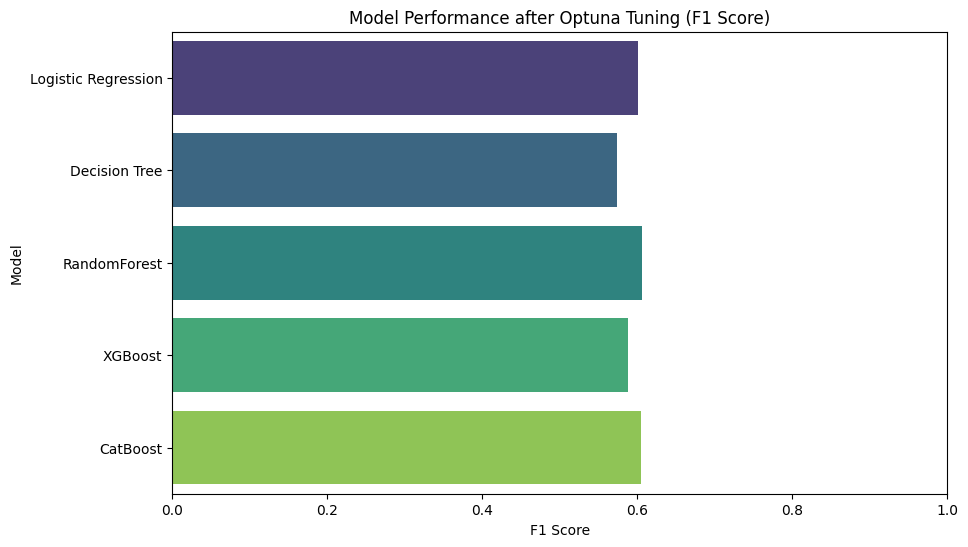

In [6]:
results = []

for name, params in best_params.items():
    print(f"Training best {name}...")
    if name == 'Logistic Regression':
        solver = params['solver']
        penalty = 'l2' # Default penalty
        l1_ratio = None
        
        if solver == 'lbfgs': 
            penalty = 'l2'
            l1_ratio = None
        elif solver == 'liblinear':
             penalty = params.get('penalty_liblinear', 'l2') 
        elif solver == 'saga':
             penalty = params.get('penalty_saga', 'l2')

        # Handle l1_ratio for elasticnet if applicable
        if penalty == 'elasticnet':
            l1_ratio = params.get('l1_ratio')

        clf = LogisticRegression(
            C=params['C'], 
            solver=solver, 
            penalty=penalty, 
            l1_ratio=l1_ratio,
            random_state=RANDOM_STATE, 
            max_iter=1000
        )
    elif name == 'Decision Tree':
        clf = DecisionTreeClassifier(**params, random_state=RANDOM_STATE)
    elif name == 'RandomForest':
        clf = RandomForestClassifier(**params, random_state=RANDOM_STATE, n_jobs=-1)
    elif name == 'XGBoost':
        clf = XGBClassifier(**params, random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False, n_jobs=-1)
    elif name == 'CatBoost':
        clf = CatBoostClassifier(**params, random_seed=RANDOM_STATE, verbose=0, thread_count=-1)
        
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'Best Params': str(params)
    })
    
    print(f"{name} - Accuracy: {acc:.4f}, F1: {f1:.4f}")

results_df = pd.DataFrame(results)
display(results_df)

# Visualize F1 Scores
plt.figure(figsize=(10, 6))
sns.barplot(x='F1 Score', y='Model', data=results_df, palette='viridis')
plt.title('Model Performance after Optuna Tuning (F1 Score)')
plt.xlim(0, 1)
plt.show()